# Introduction

During the 5th project of the Master of Data Science, we had to do a segmentation of customers based on their behavior. 
In order to classify the type of articles they are interested in, a clustering has been done on the article. To merge products together some keywords or info has been removed (for example the quantity or the color). This allow to consider that a white lamp and a red lamp are the same article. 

This clustering was poor. Nearly all articles were on 1 bucket. The silhouette score was also very low due to overlapping clusters (you can see result on the notebook @ <a href="https://github.com/Coni63/OC_DS/blob/master/P5/Segmentation%20Client.ipynb">this link</a>).

In project 6, I discovered text processing principle and fex days ago, an article about a new way to reduce dimension called UMAP (<a href="https://github.com/Coni63/OC_DS/blob/master/P5/Segmentation%20Client.ipynb">Arxiv</a>). In this Notebook, we gonna try this new algorithm compare to TSNE and improve the Clustering of articles.

I won't restart all the word done under the P5 but only do this part.

In [1]:
import pandas as pd
import nltk
import numpy as np
import time

import scipy
import scipy.sparse
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.externals import joblib

import umap   # downloaded from Github but avaialabel with pip

%matplotlib inline

In [2]:
df = pd.read_excel("F:\\Nicolas\\PycharmProjects\\machine_learning\\datasets\\Online_Retail.xlsx")

# Cleanup

As I restart from the origianl dataset, I'll do again the cleaning required to have clean articles.

In [3]:
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

In [4]:
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]
df = df[df["Description"].str.contains("LOST") == False]
df = df[df["CustomerID"].notnull()]

In [20]:
df = df["Description"].drop_duplicates().reset_index(drop=True)

In [21]:
df.to_csv("F:\\Nicolas\\PycharmProjects\\machine_learning\\datasets\\Online_Retail_clean.csv")

Now we have only unique items. This is 3800 items only. Now we will pre-process them to do the clustering afterward.

# Pre-processing articles

In [2]:
df = pd.read_csv("F:\\Nicolas\\PycharmProjects\\machine_learning\\datasets\\Online_Retail_clean.csv", index_col=0)

In [22]:
df.head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: Description, dtype: object

In [3]:
X = df #.values

You can take a look at the Tokenisation with nltk below but as we will do the TF-IDF matrix, all this processing will be done with sklearn

In [4]:
# X = X.str.lower()
# X = X.apply(nltk.word_tokenize)
# X = X.apply(lambda tokens : [stemmer.stem(token) for token in tokens if token not in stopword])
# X = X.apply(lambda tokens : [token for token in tokens if token.isalpha()])
# df["Token"] = X

In [5]:
stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

In [6]:
def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

### TF Matrix

For tests, we can also generate the TF Matrix but we won't use it.

In [27]:
analyzer = CountVectorizer().build_analyzer()
CV = CountVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter)
TF_matrix = CV.fit_transform(X)

In [28]:
joblib.dump(CV, 'CountVectorizer.pkl') 

['CountVectorizer.pkl']

In [29]:
TF_matrix

<3856x1688 sparse matrix of type '<class 'numpy.int64'>'
	with 16214 stored elements in Compressed Sparse Row format>

In [30]:
scipy.sparse.save_npz("TF_matrix.npz", TF_matrix)

### TF-IDF Matrix

The code is the same for the TF-IDF matrix but we will ignore words appearing in more than 90% of items (in case there is a kind of StopWords not in "english" list)

In [31]:
analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.9)
TF_IDF_matrix = CV.fit_transform(X)

In [32]:
joblib.dump(CV, 'TfidfVectorizer.pkl') 

['TfidfVectorizer.pkl']

In [33]:
TF_IDF_matrix

<3856x1688 sparse matrix of type '<class 'numpy.float64'>'
	with 16214 stored elements in Compressed Sparse Row format>

In [35]:
scipy.sparse.save_npz("TF_IDF_matrix.npz", TF_IDF_matrix)

What we can see is that the threshold of 90 % of word in common removed no words. This is a good point beacuse that can be analyse as the fact there there is no word too common. Now, let's do the clustering.

# Clustering

In this phase, we goona do the clustering with KMeans on the TF and TF-IDF Matrix to compare results. In we apply directly the clustering on those matrix, we will hav eissues as our matrices are very sparse and the computation of distances will be a mess. What we can do, is to performa LSA to reduce data to a dense matrix of dimension 100.

In [7]:
TF_matrix = scipy.sparse.load_npz("TF_matrix.npz").astype(np.uint8)
TF_IDF_matrix = scipy.sparse.load_npz("TF_IDF_matrix.npz")

Let's now apply the LSA and normalize every row afterward.

In [8]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_embedded = svd.fit_transform(TF_matrix)
TF_embedded = normalizer.fit_transform(TF_embedded)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)

Now, let's compute silhouette_score for both matrices

In [39]:
n_cluster_opti_tf = 0
n_cluster_opti_tf_idf = 0
score_tf = []
score_tfidf = []

max_silhouette = -1
for n_clusters in range(2, 100, 2):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_embedded)
    clusters = kmeans.predict(TF_embedded)
    silhouette_avg = silhouette_score(TF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    score_tf.append(silhouette_avg)
    if silhouette_avg > max_silhouette:
        n_cluster_opti = n_clusters

max_silhouette = -1
for n_clusters in range(2, 100, 2):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    score_tfidf.append(silhouette_avg)
    if silhouette_avg > max_silhouette:
        n_cluster_opti = n_clusters

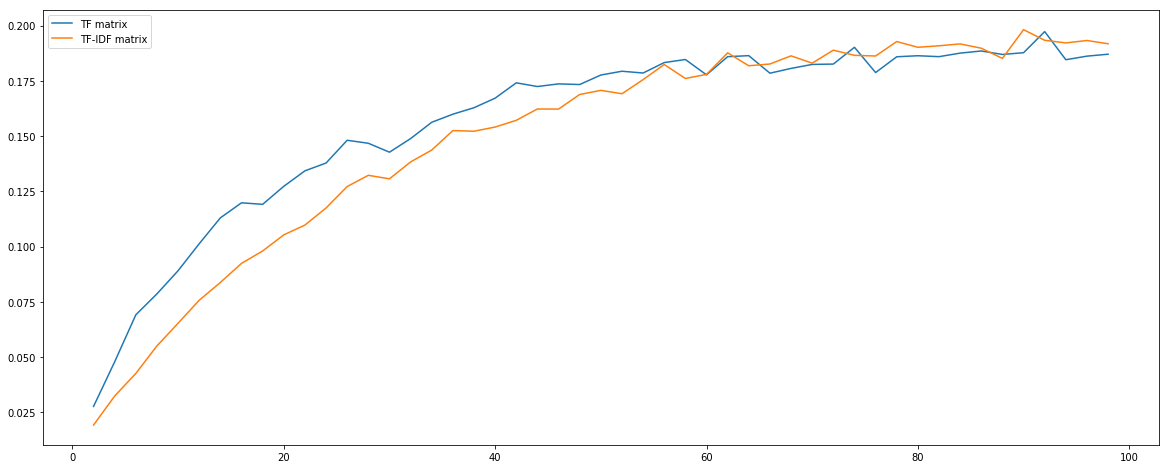

In [44]:
x = list(range(2, 100, 2))
plt.figure(figsize=(20,8))
plt.plot(x, score_tf, label="TF matrix")
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.legend()
plt.show()

Starting at 60 clusters, we have a sihouette score correct, We can see that starting at 60 clusters, the score is slightly better with the TF-IDF matrix but if we absolutely need less cluster, we should use TF matrix. Now let's do the final clustering with 60 clusters and TF-IDF matrix

In [9]:
n_clusters = 60

In [11]:
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)

# Result

Let's look at the content of clusters and the distribution

In [12]:
selected_cluster = 18
for obj, cluster in zip(X, clusters):
    if cluster == selected_cluster:
        print(obj)

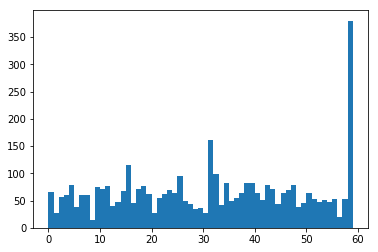

In [13]:
plt.hist(clusters, bins=n_clusters-1)
plt.show()

We can see that now, most of the clusters have the same amount of items except the cluster 8/34/59. If we look at content, it's pretty similar for all of them

# Visualisation

Here, we will try the UMAP reduction model vs TSNE. On UMAP, there is a lot of parameter we can play with :

    ==>> Uniform Manifold Approximation and Projection <<==

    Finds a low dimensional embedding of the data that approximates
    an underlying manifold.

    Parameters
    ----------
    n_neighbors: float (optional, default 15)
        The size of local neighborhood (in terms of number of neighboring
        sample points) used for manifold approximation. Larger values
        result in more global views of the manifold, while smaller
        values result in more local data being preserved. In general
        values should be in the range 2 to 100.

    n_components: int (optional, default 2)
        The dimension of the space to embed into. This defaults to 2 to
        provide easy visualization, but can reasonably be set to any
        integer value in the range 2 to 100.

    metric: string or function (optional, default 'euclidean')
        The metric to use to compute distances in high dimensional space.
        If a string is passed it must match a valid predefined metric. If
        a general metric is required a function that takes two 1d arrays and
        returns a float can be provided. For performance purposes it is
        required that this be a numba jit'd function. Valid string metrics
        include:
            * euclidean
            * manhattan
            * chebyshev
            * minkowski
            * canberra
            * braycurtis
            * mahalanobis
            * wminkowski
            * seuclidean
            * cosine
            * correlation
            * haversine
            * hamming
            * jaccard
            * dice
            * russelrao
            * kulsinski
            * rogerstanimoto
            * sokalmichener
            * sokalsneath
            * yule
        Metrics that take arguments (such as minkowski, mahalanobis etc.)
        can have arguments passed via the metric_kwds dictionary. At this
        time care must be taken and dictionary elements must be ordered
        appropriately; this will hopefully be fixed in the future.

    n_edge_samples: int (optional, default None)
        The number of edge/1-simplex samples to be used in optimizing the
        low dimensional embedding. Larger values result in more accurate
        embeddings. If None is specified a value will be selected based on
        the size of the input dataset (typically around dataset_size * 10**4).

    alpha: float (optional, default 1.0)
        The initial learning rate for the embedding optimization.

    init: string (optional, default 'spectral')
        How to initialize the low dimensional embedding. Options are:
            * 'spectral': use a spectral embedding of the fuzzy 1-skeleton
            * 'random': assign initial embedding positions at random.
            * A numpy array of initial embedding positions.

    min_dist: float (optional, default 0.1)
        The effective minimum distance between embedded points. Smaller values
        will result in a more clustered/clumped embedding where nearby points
        on the manifold are drawn closer together, while larger values will
        result on a more even dispersal of points. The value should be set
        relative to the ``spread`` value, which determines the scale at which
        embedded points will be spread out.

    spread: float (optional, default 1.0)
        The effective scale of embedded points. In combination with ``min_dist``
        this determines how clustered/clumped the embedded points are.

    set_op_mix_ratio: float (optional, default 1.0)
        Interpolate between (fuzzy) union and intersection as the set operation
        used to combine local fuzzy simplicial sets to obtain a global fuzzy
        simplicial sets. Both fuzzy set operations use the product t-norm.
        The value of this parameter should be between 0.0 and 1.0; a value of
        1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy
        intersection.

    local_connectivity: int (optional, default 1)
        The local connectivity required -- i.e. the number of nearest
        neighbors that should be assumed to be connected at a local level.
        The higher this value the more connected the manifold becomes
        locally. In practice this should be not more than the local intrinsic
        dimension of the manifold.

    gamma: float (optional, default 1.0)
        Weighting applied to negative samples in low dimensional embedding
        optimization. Values higher than one will result in greater weight
        being given to negative samples.

    bandwidth: float (optional, default 1.0)
        The effective bandwidth of the kernel if we view the algorithm as
        similar to Laplacian eigenmaps. Larger values induce more
        connectivity and a more global view of the data, smaller values
        concentrate more locally.

    a: float (optional, default None)
        More specific parameters controlling the embedding. If None these
        values are set automatically as determined by ``min_dist`` and
        ``spread``.
    b: float (optional, default None)
        More specific parameters controlling the embedding. If None these
        values are set automatically as determined by ``min_dist`` and
        ``spread``.

    random_state: int, RandomState instance or None, optional (default: None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    metric_kwds: dict (optional, default {})
        Arguments to pass on to the metric, such as the ``p`` value for
        Minkowski distance.

    angular_rp_forest: bool (optional, default False)
        Whether to use an angular random projection forest to initialise
        the approximate nearest neighbor search. This can be faster, but is
        mostly on useful for metric that use an angular style distance such
        as cosine, correlation etc. In the case of those metrics angular forests
        will be chosen automatically.

    verbose: bool (optional, default False)
        Controls verbosity of logging.

I've tried some setting and I got the best visual result with euclidean distance

In [14]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [18]:
metric = "rogerstanimoto"

In [19]:
start = time.time()
model = umap.UMAP(metric=metric)
u = model.fit_transform(TF_IDF_embedded)
print(time.time()-start)

C:\python36\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


26.80385422706604


In [20]:
start = time.time()
tsne = TSNE(n_components=2, metric = metric)
u2 = tsne.fit_transform(TF_IDF_embedded)
print(time.time()-start)

97.88580656051636


In [21]:
req = 100
selection = min(n_clusters+1, req)

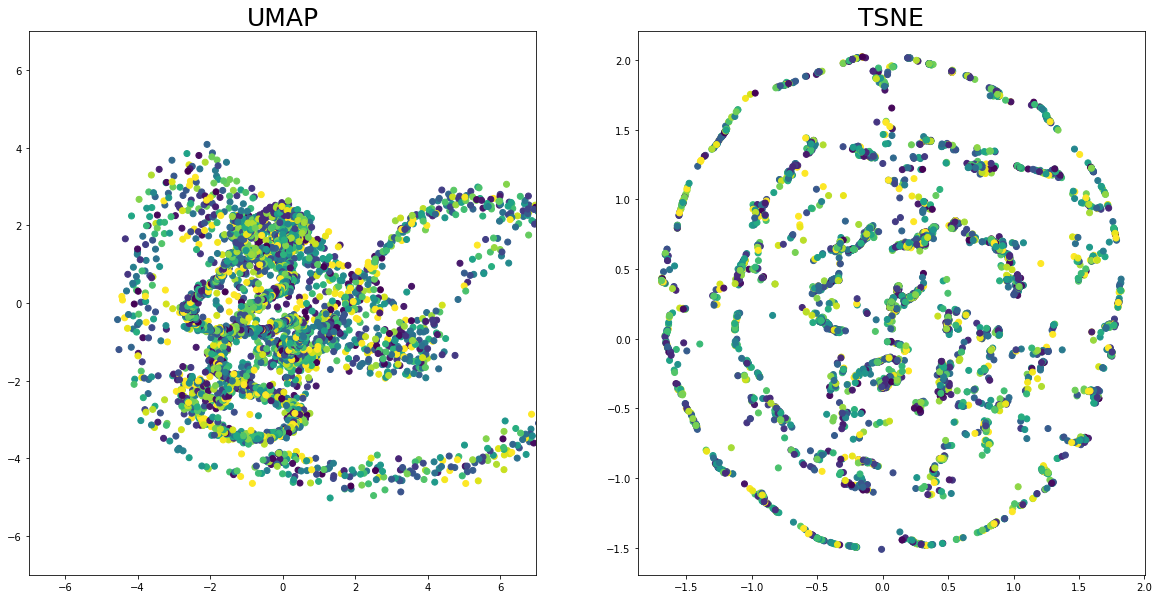

In [23]:
plt.figure(figsize=(20,10))

a1 = u[clusters<selection, :]
a2 = u2[clusters<selection, :]
b = clusters[clusters<selection]

plt.subplot(1, 2, 1)
plt.scatter(a1[:,0], a1[:,1], c=b)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("UMAP", fontsize="25")

plt.subplot(1, 2, 2)
plt.scatter(a2[:,0], a2[:,1], c=b)
plt.title("TSNE", fontsize="25")

plt.show()

# Conclusion

As a conclusion, we have improved a lot the clustering of articles based on the learning done during project 6. Now we have a balanced clustering and clearly more separated. 

Regarding the learning with UMAP, this new algorithm provides excellent results when you take a look at their paper. Nevertheless, in our case, the result is not as good as TSNE but the algorithm is clearly faster (6.8s vs 86.9s with TSNE). The fact that we can play also with distances allow us to more represent elements in proper space.